# Decision trees

### Procedure 
The documet is split in 4 sections:
- data wrangling
- model training
- evaluation
- result

In [24]:
import sys
sys.path.append("../../..")

import pandas as pd
import numpy as np
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import RepeatedStratifiedKFold, GridSearchCV
from imblearn.pipeline import Pipeline
from sklearn.model_selection import cross_validate

## Data Wrangling

In [25]:
from pyadlml.datasets import set_data_home, fetch_amsterdam, fetch_aras, fetch_uci_adl_binary

set_data_home('/home/chris/code/adlml/data_home')
data = fetch_amsterdam(cache=True)

In [27]:
from pyadlml.preprocessing import RawEncoder
from pyadlml.preprocessing import LabelEncoder

t_res = None
idle = True
st='int_coverage'

enc_raw = RawEncoder(t_res=t_res, sample_strat=st)
raw = enc_raw.fit_transform(data.df_devices)

enc_lbl = LabelEncoder(raw, idle=idle)
lbls = enc_lbl.fit_transform(data.df_activities)

In [29]:
# label the activities and drop the duplicates
raw['activities'] = lbls
raw = raw.reset_index(drop=True)
raw = raw.drop_duplicates()
raw = raw.reset_index(drop=True)

In [14]:
lbls = raw['activities']

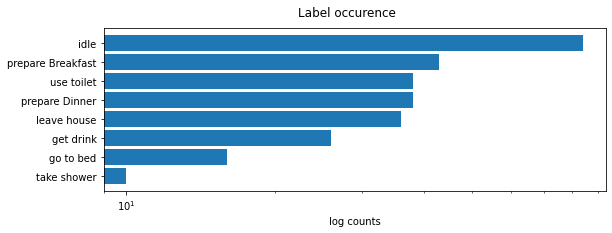

In [16]:
from pyadlml.dataset.plot.raw import hist_activities

hist_activities(enc_lbl.inverse_transform(lbls), scale='log')

The dataset is imbalanced as the labels aren't distributed equally between the classes. 
https://imbalanced-learn.readthedocs.io/en/stable/generated/imblearn.under_sampling.NearMiss.html#imblearn.under_sampling.NearMiss


In [17]:
from imblearn.under_sampling import RandomUnderSampler

st = 'not minority' # resample all but minority
#st = 'not majority' # resample all but majority
X = raw.iloc[:,:-1].astype(int).values
y = lbls.values

undersample = RandomUnderSampler(sampling_strategy=st)
X_u, y_u = undersample.fit_resample(X,y)

(80, 14)


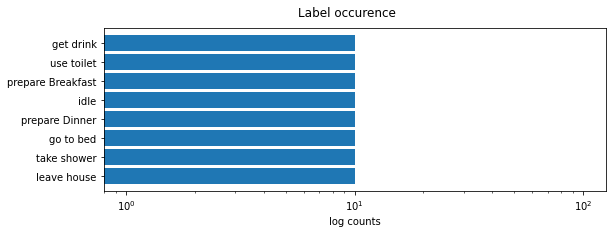

In [18]:
print(X_u.shape)
hist_activities(enc_lbl.inverse_transform(y_u), scale='log')

In [30]:
from pyadlml.preprocessing import RawEncoder
from pyadlml.preprocessing import LabelEncoder

#t_res = '10s'
t_res = None
idle = True
st='int_coverage'

enc_raw = RawEncoder(t_res=t_res, sample_strat=st)
raw = enc_raw.fit_transform(data.df_devices)

enc_lbl = LabelEncoder(raw, idle=idle)
lbls = enc_lbl.fit_transform(data.df_activities)

In [58]:
from pyadlml.model_selection import LeaveOneDayOut

lodo = LeaveOneDayOut(num_days=1)
ts = lodo.split(X=raw, y=lbls)

X = raw
y = lbls

for train_index, test_index in ts:
    X_train, X_test = X.iloc[train_index].values, X.iloc[test_index].values
    y_train = y.iloc[train_index].values.ravel()
    y_test = y.iloc[test_index].values.ravel()

# Model: Decision Tree

In [59]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import RepeatedStratifiedKFold, GridSearchCV
from imblearn.pipeline import Pipeline
from sklearn.model_selection import cross_validate

steps = []

# 1. resample the data because of the labels
undersample = RandomUnderSampler()
steps.append(('under', undersample))

# 2. Model: decision tree
model = DecisionTreeClassifier()
steps.append(('model', model))
pipe = Pipeline(steps=steps)

# evaluate pipeline
n = 10
scoring_fcts = ['f1_macro']#, 'accuracy', 'recall']
param_grid = {
    'under__sampling_strategy' : ['not majority'],
    'model__max_depth' : [2,3,4],
    'model__min_samples_leaf': [1,2,3]
}

scores = np.zeros(n, dtype=np.float32)
best_param = (0.0, {})
for i in range(n):
    cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3)
    gscv = GridSearchCV(pipe, param_grid, refit='f1_macro', 
                        scoring=scoring_fcts, cv=cv, n_jobs=-1)
    gscv.fit(X_train, y_train)
    scores[i] = gscv.best_score_
    if scores[i] > best_param[0]:
        best_param = ((scores[i], gscv.best_params_))

In [34]:
print('F1 mean Score: {:.4f}, std: {:.4f}'.format(scores.mean(), scores.std()))
print('F1 best Score: {:.4f}'.format(best_param[0]))

F1 mean Score: 0.1453, std: 0.0014
F1 best Score: 0.1469


In [35]:
best_pipe = Pipeline(steps=steps)
best_pipe = best_pipe.set_params(**best_param[1])
best_pipe = best_pipe.fit(X_train, y_train)
best_model = best_pipe.get_params()['model']

In [23]:
from sklearn import tree
import graphviz 
from IPython.display import display

dot_data = tree.export_graphviz(best_model, out_file=None)
graph = graphviz.Source(dot_data)
display(graph)#, width = 600, height = 300)

NameError: name 'best_model' is not defined

# Evaluation

In [51]:
from sklearn.dummy import DummyClassifier

def score_dummies(X_train, y_train, X_test, y_test, n=100):
    strats = ['stratified', 'most_frequent', 'uniform']
    means = {strats[0] : np.zeros(n), strats[1] : np.zeros(n), strats[2] : np.zeros(n)}

    for i in range(n):
        for strat in strats:
            dclf = DummyClassifier(strategy=strat).fit(X_train, y_train)
            means[strat][i] = dclf.score(X_test, y_test)

    for strat in strats:
        std = means[strat].std()
        mean = means[strat].mean()
        means[strat] = {'std': std, 'mean':mean}
    return means

n = 100
score_dummies(X_train, y_train, X_test, y_test, n)

{'stratified': {'std': 0.037150667072824516, 'mean': 0.17054054054054057},
 'most_frequent': {'std': 5.551115123125783e-17, 'mean': 0.3693693693693693},
 'uniform': {'std': 0.03126775122808572, 'mean': 0.11522522522522523}}

### confusion matrix

In [53]:
from sklearn.metrics import confusion_matrix

y_true = y_test
y_pred = best_model.predict(X_test)
confusion_matrix(y_true, y_pred)

array([[ 0,  0,  0,  0,  0,  0,  0,  0],
       [ 0,  0,  0,  0,  0,  0,  0, 13],
       [ 0,  0,  0,  0,  0,  0,  0, 14],
       [ 0,  0,  0,  2,  0,  0,  0,  3],
       [ 3,  0,  0,  0,  0,  0,  0,  7],
       [ 3,  0,  0,  0,  0,  0,  0, 17],
       [ 0,  0,  0,  0,  0,  0,  0,  8],
       [ 0,  0,  0,  0,  0,  0,  0, 41]])

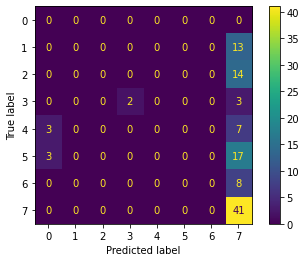

In [56]:
from sklearn.metrics import plot_confusion_matrix
plot_confusion_matrix(best_model, X_test, y_test);

In [57]:
from sklearn.metrics import classification_report

y_true = y_test
y_pred = best_model.predict(X_test)
confusion_matrix(y_true, y_pred)

array([[ 0,  0,  0,  0,  0,  0,  0,  0],
       [ 0,  0,  0,  0,  0,  0,  0, 13],
       [ 0,  0,  0,  0,  0,  0,  0, 14],
       [ 0,  0,  0,  2,  0,  0,  0,  3],
       [ 3,  0,  0,  0,  0,  0,  0,  7],
       [ 3,  0,  0,  0,  0,  0,  0, 17],
       [ 0,  0,  0,  0,  0,  0,  0,  8],
       [ 0,  0,  0,  0,  0,  0,  0, 41]])

In [28]:
from pyadlml.model_selection import LeaveOneDayOut

lodo = LeaveOneDayOut(num_days=1)
ts = lodo.split(X=raw, y=lbls)

X = raw
y = lbls

for train_index, test_index in ts:
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train = y.iloc[train_index]
    y_test = y.iloc[test_index]
    
from sklearn.dummy import DummyClassifier

strat='stratified'

dclf = DummyClassifier(strategy=strat).fit(X_train, y_train)
y_pred = dclf.predict(X_test)
y_true = enc_lbl.inverse_transform(y_test)

In [29]:
enc_lbl = LabelEncoder(raw, idle=idle)
lbls = enc_lbl.fit_transform(data.df_activities)

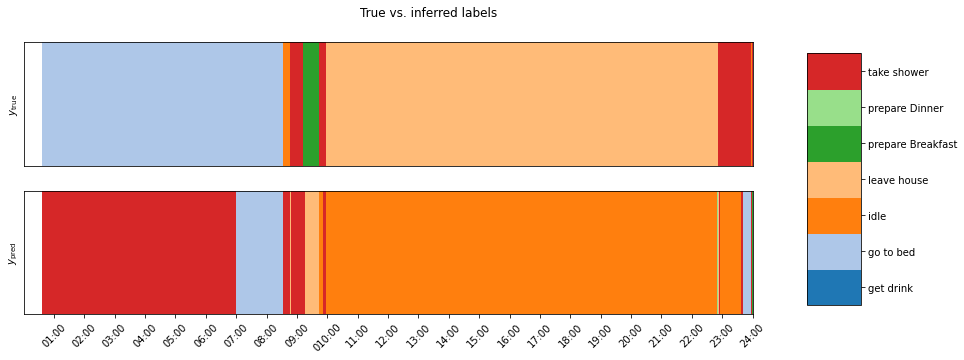

In [30]:
from pyadlml.metrics import plot_true_vs_inf_y
plot_true_vs_inf_y(enc_lbl, y_true, y_pred, index=y_true.index)

In [34]:
y_true.head(50)

time
2008-03-20 00:34:38            go to bed
2008-03-20 00:34:39            go to bed
2008-03-20 00:34:42            go to bed
2008-03-20 00:35:10           use toilet
2008-03-20 00:35:13           use toilet
2008-03-20 00:35:39           use toilet
2008-03-20 00:35:40           use toilet
2008-03-20 00:35:43           use toilet
2008-03-20 00:35:44           use toilet
2008-03-20 00:35:45           use toilet
2008-03-20 00:35:59           use toilet
2008-03-20 00:36:17            go to bed
2008-03-20 06:57:51            go to bed
2008-03-20 06:57:52            go to bed
2008-03-20 06:57:55           use toilet
2008-03-20 06:57:56           use toilet
2008-03-20 06:57:57           use toilet
2008-03-20 06:57:58           use toilet
2008-03-20 06:58:15           use toilet
2008-03-20 06:58:31           use toilet
2008-03-20 06:58:32           use toilet
2008-03-20 06:58:33           use toilet
2008-03-20 06:58:37           use toilet
2008-03-20 06:58:43            go to bed
2008-03-20 

In [26]:
y_pred

array([5, 3, 1, 7, 2, 5, 6, 2, 7, 3, 7, 0, 7, 6, 2, 5, 7, 3, 2, 0, 5, 5,
       7, 2, 6, 0, 5, 4, 3, 4, 2, 4, 3, 7, 5, 7, 4, 7, 4, 3, 7, 7, 1, 7,
       7, 7, 3, 2, 4, 7, 7, 4, 6])